On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

There are a lot of good data analysis notebooks already available on kaggle. A good summary of the approaches can be found here:
* https://www.kaggle.com/startupsci/titanic-data-science-solutions

In this notebook we will go through some simple analysis and refer to the tools that you have seen in the Datacamp courses. We will train a couple of simple models to predict the survival rate with machine learning. First, let's list the data that are available on this kaggle notebook

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In the input folder we find the train and test data, plus an example of a submission file. This last file gives us an idea of how to structure our own submission file. 

# **Data exploration and cleaning**

As a first step, we will explore the distribution of data, their correlation and type. First, let's import the main methods and load the datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')

In [2]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From the competition description, we also know what each column represents:
* survival -> Survival -> 0 = No, 1 = Yes
* pclass -> Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd
* sex -> Sex -> male/female
* Age -> Age in years
* sibsp -> # of siblings / spouses aboard the Titanic
* parch -> # of parents / children aboard the Titanic
* ticket -> Ticket number
* fare -> Passenger fare
* cabin -> Cabin number
* embarked -> Port of Embarkation -> C = Cherbourg, Q = Queenstown, S = Southampton

With .info() we check numerical/categorical columns

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Cleaning categorical features

To get some info on non-numerical variables, we can still use the .describe() command but we need to pass the argument include=['object']

In [4]:
train_df.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
train_df[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


Some important remarks:
* Names are unique across the dataset (count=unique=891)
* Sex variable has two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. In other words, several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

**Question 1)**

Among the categorical features listed above, and in absence of other information, which do you think are the least useful features for predicting survival (choose one):

a) Sex and Name \
b) Name and embarkation location \
c) Ticket and Cabin numbers \
d) Ticket number and Name 

In [6]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

To simplify our analysis, we will drop the 'Ticket', 'Cabin' and 'Embarked' columns.

In [7]:
train_df = train_df.drop(['Ticket', 'Cabin', 'Embarked'], axis=1)

**Creating new features from existing ones: Titles from Names**

In [8]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708


In [10]:
train_df['Title'] = train_df.Name.str.extract('([A-Za-z]+)\.')

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [11]:
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Encoding categorical variables into numbers can be often problematic. There are many ways to do this, which you will see in the next courses. Here, we will keep it simple and just assign to each string a number 

In [12]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['is_female'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,is_female
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,3,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,3,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,1,0


It is often useful to encode categorical variables into one-hot encodings. 

In [13]:
train_df[['is_mr', 'is_miss', 'is_mrs', 'is_master', 'is_rare_title']] = pd.get_dummies(train_df["Title"])

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Title,is_female,is_mr,is_miss,is_mrs,is_master,is_rare_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,1,0,1,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,3,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,2,1,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,3,1,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,1,0,1,0,0,0,0


At this point, we can drop the 'Name', 'Sex' and 'Title' columnns

In [15]:
train_df.drop(['Name', 'Sex', 'Title'] , axis=1, inplace = True)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_female,is_mr,is_miss,is_mrs,is_master,is_rare_title
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,1,0,0,0
3,4,1,1,35.0,1,0,53.1000,1,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,0,0


# Cleaning Numerical features

Now that we have dealt with categorical columns in our dataframe, we can move on to analysing the numerical columns.

Contrary to before, we will start with creating some new features that may help in our modelling. First, we associate for each passenger the number of family members

In [18]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby('FamilySize').mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


Another similar feature we can extract is whether a person was alone or not

In [19]:
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [20]:
train_df.drop(['SibSp', 'Parch'] , axis=1, inplace = True)

Next, we examine the feature correlation, missing values and their most interesting statistical properties using the pandas profiler. It creates an interactive html page which can be downloaded

In [21]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title="Titanic Survival Report", explorative=True)
profile.to_file("titanic_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

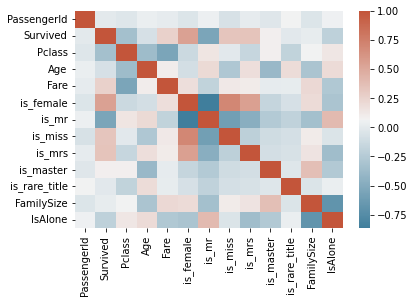

In [22]:
corr_matr = train_df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matr, cmap = cmap)

**Question 2)**

Given the correlation matrix, which feature is likely going to be the **least** important for our modelling (choose one)?

a) is_female \
b) Fare \
c) PassengerId \
d) Not enough info / they are all very important

From the plots, we have seen that the 'PassengerId' columns has almost no correlation with the other columns. Therefore, we will drop it from the training dataframe (we will keep in on the test_df because it is used for scoring our submission kaggle matches PassengerID to our answer)>

In [ ]:
train_df = train_df.drop(['PassengerId'], axis=1)

**Conclusions from data analysis and feature extraction**

**Dropped features**

* Ticket feature was be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
* Cabin feature was be dropped as it is highly incomplete or contains many null values both in training and test dataset.
* PassengerId was be dropped from training dataset as it not correlated to survival.


**Created features**

* Created a new feature called Family based on Parch and SibSp to get total count of family members on board.
* Extracted Title from Name as a new feature. One-hot encoded it for modelling

# Model training and testing

In this section we will train and test one Knn and one Random forest classifier to predict survival rates. However, in our dataset there are still some missing values

**Question 3)**

What do we do with missing values?

a) We fill them with the column mean/median \
b) We drop the column \
c) Depends on the algorithm that we use \
d) We fill them with an out-of-sample value (e.g. default_age = -10)

Let's created the proper train and validation set from the traind_df dataframe

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X = train_df.loc[:, train_df.columns != 'Survived']
y = train_df.loc[:, 'Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

**Question 4)**

We are now going to train 4 different models, 2 Knn (one scaled, one not) and 2 Random Forest models (also, one scaled, one not). What to we expect from scaling the input data?

a) Knn score improves, Random forest remains (more or less) the same \
b) Both Knn and Random forest scores improve \
c) Both scores remain the same (more or less) \
d) Both scores get worse

# KNN training and scoring

In sklearn, both Knn and Random Forests do not handle missing values internally. Therefore, we need to impute the missing values before passing it through the models

In [ ]:
X_train = X_train.fillna(X_train.mean())
X_val= X_val.fillna(X_val.mean())

We can now move on to training the KNN model

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
knn.score(X_val, y_val)

In [ ]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
knn.score(X_val_scaled, y_val)

In this example we have only used a standard scaler, but often other types of scaling yield better results. For example, some features may benefit from log scaling their values (typical for "fat tails")

In [ ]:
sns.pairplot(train_df[['Fare', 'Age']])

# Random forest training and scoring

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(f'accuracy score: {accuracy_score(rf.predict(X_val), y_val)}')
print(f'Feature importance: \n {dict(zip(X.columns, rf.feature_importances_.round(2)))}')

In [ ]:
rf.fit(X_train_scaled, y_train)
print(f'accuracy score: {accuracy_score(rf.predict(X_val_scaled), y_val)}')
print(f'Feature importance: \n {dict(zip(X.columns, rf.feature_importances_.round(2)))}')

Notice that a feature being correlated to survival does not necessarily mean that the feature importance in a model is going to be high

In [ ]:
corr_matr = train_df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matr, cmap = cmap)